# import modules and define functions

In [42]:
# import libraries
from math import * 
import math
import sympy as sy
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib widget
import trackpy as tp
import os
import pickle
import re

from scipy import signal
from scipy.signal import find_peaks
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import fft, fftfreq
from scipy import optimize
from sklearn.cluster import DBSCAN
from scipy.optimize import leastsq

# --> Change globally the fonts of the plots:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({ 'font.sans-serif':'Arial'})
# to restore defaults use:    mpl.rc_file_defaults()

In [43]:
# Used function in the program:

def norm_of_vec(V):
    # calculate the norm of a vector:
    return sy.sqrt(V[0]**2+V[1]**2+V[2]**2)


def cross_product(U,V):
    # Calculate the cross product of two vectors: W = U x V
    e1,e2,e3 = 1,1,1 # assuming that all the magnitudes are 1
    W1 = e1*(U[1]*V[2]-U[2]*V[1])
    W2 = e2*(U[2]*V[0]-U[0]*V[2])
    W3 = e3*(U[0]*V[1]-U[1]*V[0])
    return [W1,W2,W3]


def angle(v, w): 
    # calculation of the angle between two vectors:
    return acos(v.dot(w)/(norm(v)*norm(w)))



def p_to_fun_dist(R2,R2_dx_roots):
    # function searches for the shortest distance between the point p of interest and
    # a list of possible x-positions (R2_dx_roots) on a spline (x,y,z)
    
    # calculate all the radii (with the roots) and select the shortest:
    lr = [R2.subs(x,xi) for xi in R2_dx_roots] # calculate all the distances
    lr = [j for j in lr if j>0] # eliminate negative distances !
    
    R2_min = min(lr) # Find the minimum distance of R2
    # R2 equals the radius sqared of the imaginary sphere that is optimized
    min_index = lr.index(R2_min)
    X_pos = R2_dx_roots[min_index]
    R_min = sqrt(R2_min)
    return X_pos,R_min



def calc_THB(m,s):
    # m curve defined as a tuple with (x,y,z)
    # s variable of the curve, default: x-coordinate
    # calculate the binomial vectors THB in a general form for a given spline
    
    # calculate T:
    T = [sy.diff(j,s) for j in m] # differentiate m
    norm_T = norm_of_vec(T) # calculate the norm of T:
    T_norm = [j/norm_T for j in T] # calculate the norm Vector of T

    # calculate H:
    H = [sy.diff(j,s) for j in T_norm] # differentiate T_norm
    norm_H = norm_of_vec(H) # calculate the norm of H:
    H_norm = [j/norm_H for j in H] # calculate the norm Vector of H

    # calculate B:
    # cross product of B = T x H
    B = cross_product(T_norm,H_norm)
    return T_norm,H_norm,B,T


def calc_THB_point(T,xr):
    # calculate THB for a given point on the spline    
    Tp = [float(j.subs(x,xr)) for j in T]
    Tpres =Tp
# #     Tpres = [j/norm(Tp) for j in Tp]
#     Hp = [float(j.subs(x,ps)) for j in H]
#     Hpres = Hp
# #     Hpres = [j/norm(Hp) for j in Hp]
#     Bp = [float(j.subs(x,ps)) for j in B]
#     Bpres = Bp
#     Bpres = [j/norm(Bp) for j in Bp]  
# Note that H and B are not used further for analysis
    return np.array(Tpres)#,np.array(Hpres),np.array(Bpres)


def filt(df, var, low, high):
    #filter function
    return df[(df[var]>=low) & (df[var]<=high)]


def rotation(alpha,v): # R - Rotation
    # mind the right sign before the rotation and 
    # also that the angle is in radians
    R = np.array([[cos(alpha), -sin(alpha),0],[sin(alpha), cos(alpha),0],[0,0,1]])
    w = R.dot(v)
    return w

def transform(locs,tx,ty,phi):
    locs['x']=(np.cos(phi)*locs['x']-np.sin(phi)*locs['y'])
    locs['x'] = locs['x'] +tx
    locs['y']= np.sin(phi)*locs['x']+np.cos(phi)*locs['y']
    locs['y'] = locs['y'] +ty
    return locs


# make a grid
def grid (start,end):
    minor_ticks=np.linspace(start,end,end+1)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_yticks(minor_ticks,minor=True)
    
    major_ticks = np.linspace(start,int(end),int(end/5+1))
    ax.set_yticks(major_ticks,major=True)
    ax.set_xticks(major_ticks,major=True)
    
    ax.grid(which="minor",alpha=0.3)
    ax.grid(which = 'major',color = 'green', linestyle = '--', linewidth = 0.5)
    
# Used sites:
# https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle
# https://www.matheboard.de/archive/598910/thread.html



def calc_average(l):
    l = [x for x in l if str(x) != 'nan']
    if len(l) > 0:
        return np.mean(l)
    else:
        return 0

    
        
def plot_D_band(ax,y):
    real_D_band = np.array(np.linspace(67,67*7,7))
    sb =  real_D_band - 5
    eb =  real_D_band + 5
    borders = [[sb[j],eb[j]] for j in range(len(real_D_band))]
    
    return [ax.fill_between(j,max(y),0,
                            color = 'green',alpha = .2,
                            label='D-banding') for j in borders]

def automatic_rot(locW):
    loc_rot = locW.copy()
    rot_threshold = max(loc_rot['z'])*0.80
    loc_rot = loc_rot[loc_rot['z']>rot_threshold]
    # --> The rot_threshold can be adjusted !
    # Step 1: Compute the centroid (mean of x and y)

    centroid_x = loc_rot['x'].mean()
    centroid_y = loc_rot['y'].mean()

    # Step 2: Center the points by subtracting the centroid
    loc_rot_centered = loc_rot.copy()
    loc_rot_centered['x'] = loc_rot['x'] - centroid_x
    loc_rot_centered['y'] = loc_rot['y'] - centroid_y

    # Step 3: Compute the covariance matrix of the centered points
    cov_matrix = loc_rot_centered[['x', 'y']].cov()

    # Step 4: Get the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # The eigenvector corresponding to the largest eigenvalue
    principal_direction = eigenvectors[:, np.argmax(eigenvalues)]

    # Step 5: Compute the angle between the principal direction and the x-axis
    angle = np.arctan2(principal_direction[1], principal_direction[0])

    # Step 6: Construct the rotation matrix (counter-clockwise)
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]])

    # Step 7: Apply the rotation matrix to the centered points (Pandas operation)
    rotated_points = loc_rot_centered[['x', 'y']].dot(rotation_matrix.T)

    # Step 8: Translate the rotated points back to the original centroid
    rotated_points.columns = ['x','y']
    rotated_points['x'] += centroid_x
    rotated_points['y'] += centroid_y
    rotated_points['z'] = loc_rot['z']

    # applying the transformation to the real data
    locW_rot_centered = locW.copy()
    locW_rot_centered['x'] = locW_rot_centered['x'] - centroid_x
    locW_rot_centered['y'] = locW_rot_centered['y'] - centroid_y
    locW_rotated_points = locW_rot_centered[['x', 'y']].dot(rotation_matrix.T)
    locW_rot = locW_rotated_points.copy()
    locW_rot.columns = ['x','y']
    locW_rot['x'] += centroid_x
    locW_rot['y'] += centroid_y
    locW_rot['z'] = locW['z']
    return locW_rot,angle,centroid_x,centroid_y


# Function to apply the same rotation to another dataframe
def apply_rotation_to_another_df(df, angle, centroid_x, centroid_y):
    df_end = df.copy()
    
    # Step 1: Center the new dataframe points
    df_centered = df.copy()
    df_centered['x'] = df['x'] - centroid_x
    df_centered['y'] = df['y'] - centroid_y
    
    # Step 2: Construct the same rotation matrix using the angle
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]])
    
    # Step 3: Apply the rotation matrix
    rotated_points = df_centered[['x', 'y']].dot(rotation_matrix.T)
    
    # Step 4: Translate the rotated points back to the original centroid
    rotated_df = rotated_points.copy()
    rotated_df.columns = ['x', 'y']
    rotated_df['x'] += centroid_x
    rotated_df['y'] += centroid_y
    rotated_df['z'] = df['z']  # Preserve 'z' values if present
    
    df_end['x'] = rotated_df['x']
    df_end['y'] = rotated_df['y']
    return df_end


# Analysis

In [44]:
# STORM localisations
List_of_val = pd.read_csv('List_of_val.csv')

# Define the fibril you would like to analyze:
ROI = '2_1_2'
fibril_num = '5_2'

Folder 'loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2' created.
Rotation angle: -99.8317863504657 degrees


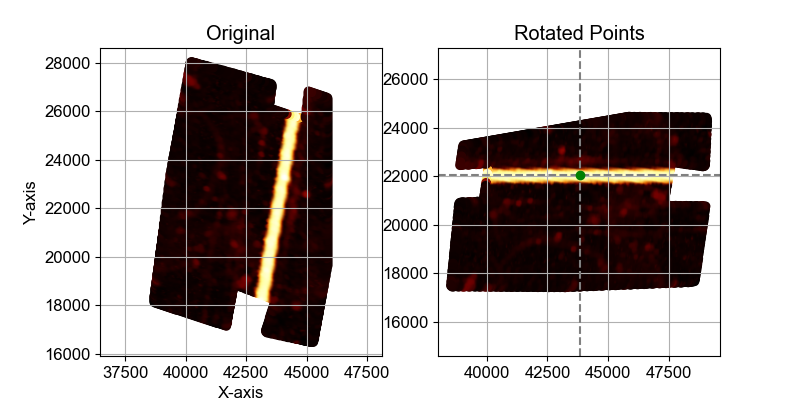

In [45]:
# Rotate the fibril, such that it is parallel to the x-axis.
# This ensures optimal fitting with a polynome

folder = f'loc_filt_GPU_results_{ROI}/'
fibrils = [f for f in os.listdir(folder) 
           if os.path.isdir(os.path.join(folder, f))]

# Specify which fibril should be analysed
fibril = f'fibril_{fibril_num}'

# Create results folder:
path_to_folder = folder+f'{fibril}/tilt_correction/'
results_folder = folder+f'{fibril}/analysis_ROI_{ROI}_{fibril}'

# Check if the folder already exists
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
    print(f"Folder '{results_folder}' created.")
else:
    print(f"Folder '{results_folder}' already exists.")

    


# import AFM file
locW = pd.read_csv(f'AFM_locs_{ROI}/fibril_{fibril_num}//AFM_wet_ROI_{ROI}_{fibril}.csv')

# Automatic Rotation of the fibril
locW_rot,angle_rot,centroid_x,centroid_y = automatic_rot(locW) # first rotation


# Visualizing the original and rotated points
fig,ax = plt.subplots(1,2,figsize=(8, 4))
ax[0].scatter(locW['x'], locW['y'],
              c=locW['z'], label='Original Points',cmap='afmhot')
ax[1].scatter(locW_rot['x'], locW_rot['y'],
              c = locW_rot['z'], label='Rotated Points',cmap='afmhot')

ax[1].scatter(centroid_x, centroid_y, c = 'green', label='Centroid', zorder=5)
ax[1].axhline(centroid_y, color='gray', linestyle='--')
ax[1].axvline(centroid_x, color='gray', linestyle='--')
ax[0].set_title('Original'), ax[1].set_title('Rotated Points')
ax[0].set_xlabel('X-axis'),ax[0].set_ylabel('Y-axis')
ax[0].grid(), ax[1].grid(), ax[0].axis('equal'), ax[1].axis('equal')
# Print the angle in degrees for reference
print(f"Rotation angle: {np.degrees(angle_rot)} degrees")
fig.savefig(results_folder+'/'+'fibril_AFM_wet_rot.png',dpi=600)


## Fit AFM Data:

A·exp[-0.5·((x-μ)/σ)^2]

Fit Values (in nm):
µ = 31768.52, σ = 183.06


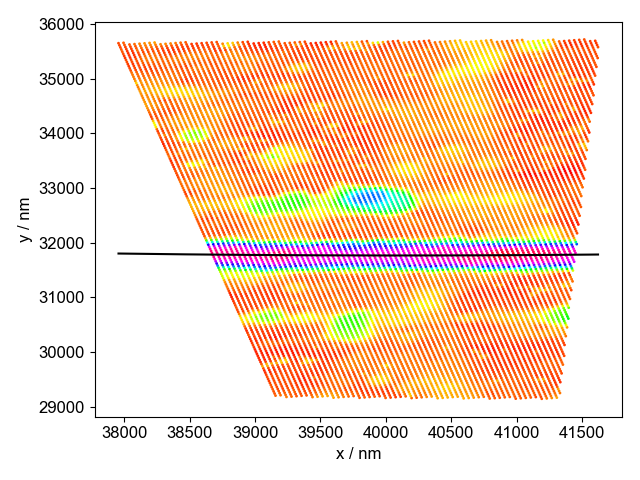

In [19]:
#### Fit the polynome though the fibril ####
# Fit the AFM data with polynome with z = 0:

# fit polynomes:
locA = locW_rot.copy() 

# reduce influence of background
AFM_th = 10 
# all fibril points  higher than this threshold are used for the polynomial fit

locA_fit = locA[locA['z']>AFM_th]
locA_fit = filt(locA_fit,'x',min(locA_fit['x'])+500,max(locA_fit['x'])-500)
# Cutoff the ends of the fibril to reduce bias


# more weight towards higher fibril datapoints
m_ax = locA_fit[locA_fit['z']>max(locA_fit['z'])*0.80]
m_ax_value = np.mean(m_ax['y']) 

# more weight towards the central axis
# this is only valid if the fibril is more or less straight
x_values = locA_fit['y']
# Gaussian fit
fitfunc = lambda p, x: p[0] * np.exp(-0.5 * ((x - p[1]) / p[2])**2)
errfunc = lambda p, x, y: y - fitfunc(p, x)
params, _ = leastsq(errfunc, [100, m_ax_value, 50], args=(locA_fit['y'],locA_fit['z']))
c = [round(p, 2) for p in params]

# Fit description
textbox = f"A·exp[-0.5·((x-μ)/σ)^2]\n\nFit Values (in nm):\nµ = {c[1]}, σ = {c[2]}"
print(textbox)
w_ax = fitfunc(c,locA_fit['y'])


# fit a 2nd order polynome:
fit_afm = np.polyfit(locA_fit['x'],locA_fit['y'],deg=2,w=locA_fit['z']*w_ax)

# the 4th order polynome is defined by:
x = sy.Symbol('x')
y_afm = np.polyval(fit_afm,x)
# y_afm = fit_afm[0]*x**4+fit_afm[1]*x**3+fit_afm[2]*x**2+fit_afm[3]*x+fit_afm[4]
z_afm = 0*x

# Binomial vectors THB
# The binomial vectors are used later on to calculate the angle of each point,
# with respect to the center of the fibril (fitted polynome)
m_AFM = [x,y_afm,z_afm]
T_AFM,H_AFM,B_AFM,T_raw_AFM = calc_THB(m_AFM,x) # note that THB depend on the x-coordinate

# evaluate for plotting:
xn = np.linspace(min(locA['x']),max(locA['x']),1000)
yn = np.polyval(fit_afm,xn)
zn = 0

fig = plt.figure()
ax = fig.add_subplot(xlabel='x / nm', ylabel='y / nm')
scat = ax.scatter(locA['x'], locA['y'], s=1,c=locA['z'],cmap='hsv')
ax.plot(xn,yn,color='black')
# ax.axis('equal')
plt.tight_layout()
plt.show()
fig.savefig(results_folder+'/'+'fibril_AFM_spline_fit.png',dpi=600)



In [20]:
####
# Creating knots on the fitted polynome to find the shortest distances
# between the polynome (knots) and the AFM-localisations (datapoints):

# --> define parameters kl and step:
kl = 1 # knot length (max dist between knots), default is 1 nm
step = kl/10 # the smaller the more precise, but slower, default is kl/10
longer_ends = 100 # make the knots a bit longer than the data

startpoint = min(locA['x'])-longer_ends  # start here to make knots
endpoint = max(locA['x'])+longer_ends    # end here to make knots

AKnots = pd.DataFrame(columns=['x1','x2','k_length','s_length'])
AKnots.loc[0]=[startpoint,startpoint,0,0]

i = 1
x1 = AKnots['x1'][0]
x2 = AKnots['x2'][0]

s_length = 0
while x2 < endpoint:
    x1 = AKnots['x2'][i-1] 
    x2 = x1+step 
    # x1 and x2 are used to calculate the distance between two knots
    # they increase each line with step size

    E1 = x.subs(x,x2)-x.subs(x,x1)
    E2 = y_afm.subs(x,x2)-y_afm.subs(x,x1)
    E3 = z_afm
    k_length = sqrt(E1**2+E2**2+E3**2) 

    while k_length < kl:
        x1 += step
        x2 += step
        E1 = x.subs(x,x2)-x.subs(x,x1)
        E2 = y_afm.subs(x,x2)-y_afm.subs(x,x1)
        E3 = z_afm
        k_length += sqrt(E1**2+E2**2+E3**2) # calc length between two knots


    s_length = AKnots['s_length'][i-1]+k_length
    AKnots.loc[i] = [x1,x2,k_length,s_length]
    i += 1 

x_values = [float(x.subs(x,AKnots['x2'].loc[j])) for j in range(len(AKnots))]
y_values = [float(y_afm.subs(x,AKnots['x2'].loc[j])) for j in range(len(AKnots))]
z_values = [float(z_afm) for j in range(len(AKnots))]

# save also the x,y,z coordinates of each knot
AKnots['x_values'] = x_values 
AKnots['y_values'] = y_values
AKnots['z_values'] = z_values

# saving the knots here:
# --> save Data for further work:
save_file_name = results_folder+'/Knots_afm_wet.csv'
AKnots.to_csv(save_file_name)
print(f'Great, your knots are now saved under: {save_file_name}')
# Analysing AFM data along polynomes


###
# sorting the data values and re-indexing
locA = locA.sort_values('x')
locA = locA.set_index(pd.Index(list(range(len(locA)))))


# Threshold knots for calculating the distances:

# filter out a cube (a=2*fl) with the poi in the center 
fl = 500 # filter length 
#filter function
def filt(df, var, low, high):
    return df[(df[var]>low) & (df[var]<high)]

Point_table = pd.DataFrame(columns=['dist','s','xs','ys','zs'])

for k in range(len(locA['x'])):

    point_x = locA['x'].iloc[k]
    point_y = locA['y'].iloc[k]
    point_z = locA['z'].iloc[k]

    Test_table_filt = filt(AKnots, 'x_values', point_x-fl, point_x+fl)

    FR = 10000 # distance should be closer than this value (> than fibril width)
    for j in range(len(Test_table_filt)):
        FR_new_x2 = (Test_table_filt['x_values'].iloc[j]-point_x)**2
        FR_new_y2 = (Test_table_filt['y_values'].iloc[j]-point_y)**2
        FR_new_z2 = (Test_table_filt['z_values'].iloc[j]-point_z)**2
        FR_new = sqrt(FR_new_x2+FR_new_y2+FR_new_z2)

        if FR_new < FR:
            FR = FR_new
            i = j
    s = Test_table_filt['s_length'].iloc[i]
    xs = Test_table_filt['x_values'].iloc[i]
    ys = Test_table_filt['y_values'].iloc[i]
    zs = Test_table_filt['z_values'].iloc[i]

    Point_table.loc[len(Point_table)] = [FR,s,xs,ys,zs]

AFM_locs_new = locA.copy()
AFM_locs_new = pd.concat([locA, Point_table],axis=1,join = 'inner') 
# merge the new list to the localisations


###
def angle(v, w): 
    # calculation of the angle between two vectors:
    return acos(v.dot(w)/(norm(v)*norm(w)))

# calculate the angles of the points
X_final, Y_final, A_final = [],[],[]

# coordinates of the spline knot:
xri = np.array(AFM_locs_new['xs'])
yri = np.array(AFM_locs_new['ys'])
zri = np.array(AFM_locs_new['zs'])

# coordinate of the point of interest:
pxi = np.array(AFM_locs_new['x'])
pyi = np.array(AFM_locs_new['y'])
pzi = np.array(AFM_locs_new['z'])

R_min_list = np.array(AFM_locs_new['dist'])

for j in range(len(AFM_locs_new)):

    # coordinates of the spline knot:
    xr = xri[j]
    yr = yri[j]
    zr = zri[j]

    # coordinate of the point of interest:
    px = pxi[j]
    py = pyi[j]
    pz = pzi[j]

    # distance of the poi to the spline
    R_min = R_min_list[j]

    # evaluate THB for a given point (xr):
    Tp = calc_THB_point(T_AFM,xr)

    # calculating the rotation such that vector T is in xy plane:
    # rotate THB around the roation axis T, 
    # so that H lies in x-y plane and has z = 0

    # define projection of T:
    Tp[2] = 0 # projecting it to the xy-plane
    pTp = Tp/norm(Tp)


    # to get the projection of H we
    # define a vector perpendicular to it:
    # (x,y,z) -> (y,-x,z) with z = 0

    pHp = pTp.copy()
    pHp[0] = pTp[1]
    pHp[1] = -pTp[0]


    if pHp[1] < 0:
        pHp = rotation(pi,pHp) # rotation to get the direction in the positive y-direction

    # pHp is the final vector to determine the angle between the horizontal (pHp) and 
    # the point of interest


    # Transform the point to the coordinate system of THB:
    # substract the point on the spline to the point of interest,
    # to get the vector of the point
    P = np.array([float(px-xr),float(py-yr),float(pz-zr)])


    # now let's calculate the angle between the point and the horizontal projection of H-vector:
    a_poi = angle(P,pHp)

    # note that we want an angle ranging from 0-360
    if P[2] < 0: 
        a_poi = 2*pi-a_poi # this ensures that the angle is always between 0 and 2pi


    # Calculate the x and y coordinates of our point of interest poi in the HB-plane:
    # the x and y values (in the HB-plane) are simply:
    X = R_min*np.cos(a_poi)
    Y = R_min*np.sin(a_poi)

    a_poi = round(degrees(a_poi),2)
    X = round(X,2)
    Y = round(Y,2)

    X_final += [X] 
    Y_final += [Y] 
    A_final += [a_poi] 


# make a final pandas data table:
AFM_Data = pd.DataFrame(list(zip(X_final, Y_final,A_final)),
                    columns =['X','Y','Angle'])

AFM_Data = pd.concat([AFM_locs_new,AFM_Data], axis=1, join="inner")



### Saving
save_file_name_AFM_wet = results_folder+'/AFM_wet_data_continue.csv'
AFM_Data.to_csv(save_file_name_AFM_wet)
print(f'Great, your data is now saved under: {save_file_name_AFM_wet}')
print(f'fibril {fibril} is analysed')

KeyboardInterrupt: 

In [ ]:
# --> Load AFM data
AFM_Data = pd.read_csv(save_file_name_AFM_wet)

fig,ax = plt.subplots(2,1)
ax[0].scatter(AFM_Data['y']-18000,AFM_Data['z'],label='before',s=1)
ax[0].scatter(AFM_Data['X'],AFM_Data['Y'],label='after',s=1)
ax[0].legend()

ax[1].scatter(AFM_Data['x']-10000,AFM_Data['y']-28000,label='before',s=1,c=AFM_Data['z'])
ax[1].scatter(AFM_Data['s'],AFM_Data['X'],label='after',s=1,c=AFM_Data['Y'])

## Fit STORM data

In [ ]:
# For the STORM data, the fibril is cut in two halfs (upper and lower part) and 
# then both parts are fitted with a spline individually. Next a central spline is fit
# through the two splines 

# This procedure ensures that there are no biases from localisations clusterings 
# (molecules that blink more than once)

z_cutoff: 92.05366386743918


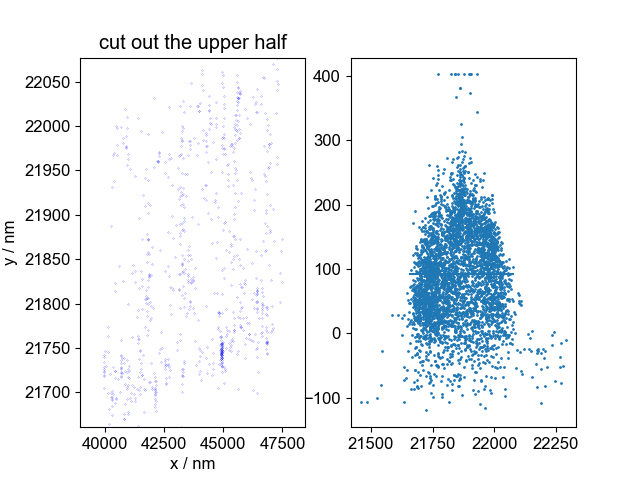

In [46]:
# import STORM files

# Get the list of all files and directories in the current directory
files_and_dirs = os.listdir(path_to_folder)

# Define the regex pattern
pattern = r"^STORM_localisations_filtered_ROI_\d*_\d*_\d*_fibril"
pattern_locs = re.compile(pattern)


# Filter files that match the pattern
matching_STORM_loc_files = [f for f in files_and_dirs if pattern_locs.match(f)]
matching_STORM_loc_files.sort()

matching_STORM_paths = [path_to_folder+f for f in matching_STORM_loc_files]
STORM_locs_list = []
STORM_defocus_list = []
for j in matching_STORM_paths:
    STORM_locs_list += [pd.read_csv(j)]
    STORM_defocus_list += [j.split('def',1)[1][:-4]]
# This list contains all the different defocus values

#### Automatic Rotation of the fibrils with same parameters as AFM
STORM_locs_list = [apply_rotation_to_another_df(j,angle_rot, centroid_x,centroid_y) for j in STORM_locs_list]


# Define the script with one example
locS = STORM_locs_list[0]
locS = locS.rename(columns={"z": "z_before_corr", "z_cor": "z"})

z_cutoff = np.mean(locS['z'])
# cut the fibril roughly in half

print(f'z_cutoff: {z_cutoff}')
locSf = filt(locS,'z',z_cutoff-20,z_cutoff+20)


fig, ax=plt.subplots(1,2)
ax[0].scatter(locSf['x'], locSf['y'], s=0.02,color = 'blue')
sel_u = mpl.widgets.PolygonSelector(ax[0], lambda x: None)  
# for Rectangle Ellipse: interactive=True)

ax[0].set_title('cut out the upper half')
ax[0].set_xlim(min(locSf['x'])-1000,max(locSf['x'])+1000)
ax[0].set_ylim(min(locSf['y']),max(locSf['y']))
ax[0].set_xlabel('x / nm')
ax[0].set_ylabel('y / nm')

ax[1].scatter(locS['y'], locS['z'],s=1)
ax[1].plot([min(locSf['y']),max(locSf['y'])],[z_cutoff,z_cutoff])

Text(0, 0.5, 'y / nm')

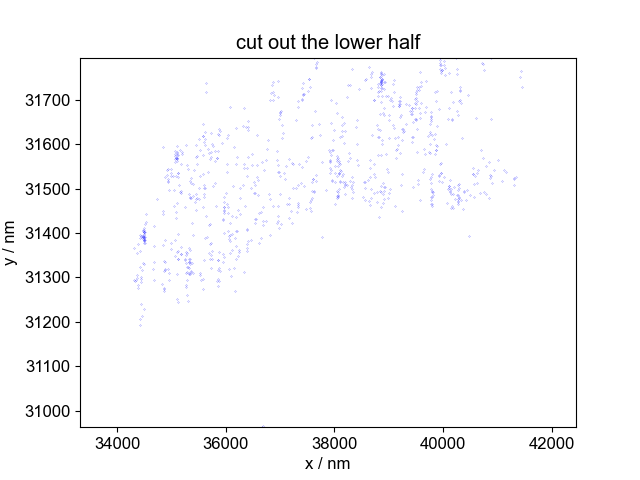

In [22]:
fig, ax=plt.subplots()
ax.scatter(locSf['x'], locSf['y'], s=0.02,color = 'blue')
sel_l = mpl.widgets.PolygonSelector(ax, lambda x: None)  # for Rectangle Ellipse: interactive=True)
ax.set_xlim(min(locSf['x'])-1000,max(locSf['x'])+1000)
ax.set_ylim(min(locSf['y']),max(locSf['y']))
ax.set_title('cut out the lower half')
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')

In [ ]:
results_folder

In [48]:
# check if you already cut them out:
if os.path.exists(results_folder+'/'+'STORM_cutout_coordinates.pkl'):
    print('cutout is already there')
    
    with open(results_folder+'/'+'STORM_cutout_coordinates.pkl', 'rb') as file:
        STORM_cutout_lu = pickle.load(file)
    path_u = STORM_cutout_lu['path_u']
    path_l = STORM_cutout_lu['path_l']
    
    Q1 = input('Do you want to change the parameters ?')
    if Q1 == 'y':
        path_u = mpl.path.Path(sel_u.verts)
        path_l = mpl.path.Path(sel_l.verts)
        STORM_cutout = dict({'path_u':path_u,'path_l':path_l})
        with open(results_folder+'/'+'STORM_cutout_coordinates.pkl', 'wb') as file:
            pickle.dump(STORM_cutout, file)
    else:
        print('old transformation used')
        
else: # Otherwise save your new cutout
    path_u = mpl.path.Path(sel_u.verts)
    path_l = mpl.path.Path(sel_l.verts)
    STORM_cutout = dict({'path_u':path_u,'path_l':path_l})
    
    with open(results_folder+'/'+'STORM_cutout_coordinates.pkl', 'wb') as file:
        pickle.dump(STORM_cutout, file)

cutout is already there
Do you want to change the parameters ?
old transformation used


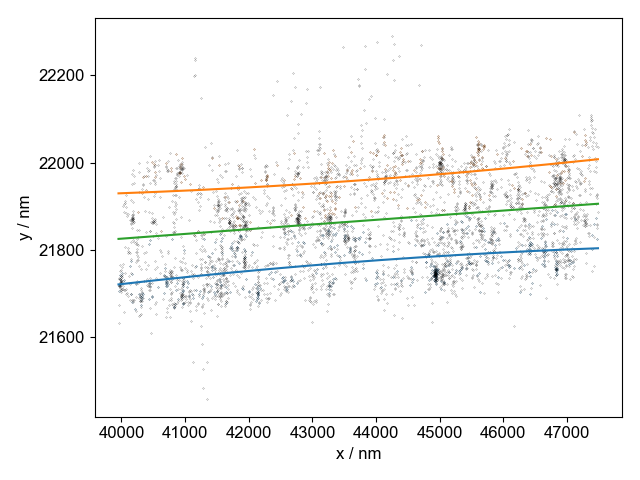

In [49]:
# Fitting of the central spline

# STORM fibril
S_sp = np.column_stack([locSf['x'], locSf['y']]) #scatter_pos
S_selected_u = path_u.contains_points(S_sp)
S_selected_l = path_l.contains_points(S_sp)
locs_u = locSf[S_selected_u]
locs_l = locSf[S_selected_l]
    
    
# fit a polynome through the m_locs
fit_l = np.polyfit(locs_l['x'],locs_l['y'],deg = 2)
fit_u = np.polyfit(locs_u['x'],locs_u['y'],deg = 2)

# evaluate for plotting:
xn_l = np.linspace(min(locS['x']),int(max(locS['x'])),1000)
yn_l = np.polyval(fit_l,xn_l)

xn_u = np.linspace(min(locS['x']),int(max(locS['x']))-1,1000)
yn_u = np.polyval(fit_u,xn_u)


# creating the mean polynome
xm = list(xn_l)+list(xn_u)
ym = list(yn_l)+list(yn_u)

dfm = pd.DataFrame(list(zip(xm,ym)),columns = ['x','y'])
dfm = dfm.sort_values('x')

fit_m = np.polyfit(dfm['x'],dfm['y'],deg = 2)
xn_m = np.linspace(min(locS['x']),int(max(locS['x'])),1000)
yn_m = np.polyval(fit_m,xn_m)


fig,ax = plt.subplots() 
ax.scatter(locs_l['x'], locs_l['y'], s=0.02)
ax.scatter(locs_u['x'], locs_u['y'], s=0.02)
ax.scatter(locS['x'], locS['y'], s=0.02,color = 'k')
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')

# ax.axis('equal')
ax.plot(xn_l,yn_l)
ax.plot(xn_u,yn_u)
ax.plot(xn_m,yn_m)

plt.tight_layout()
plt.show()
fig.savefig(results_folder+'/'+'fibril_storm_spline_fit.png',dpi=600)

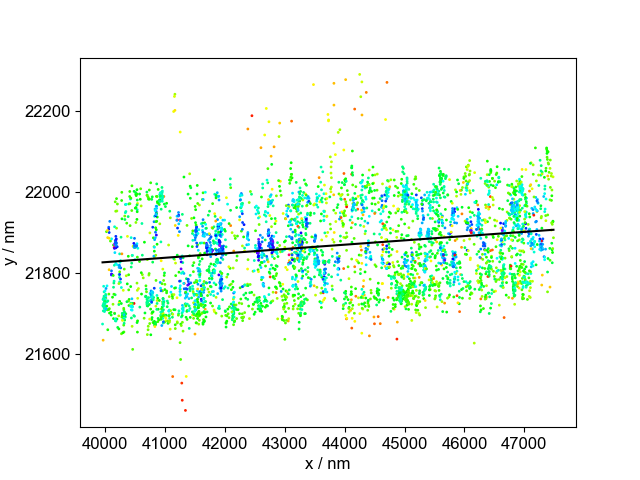

In [50]:


# visualise the polynome:
fit_storm = fit_m

# evaluate for plotting:
xn = np.linspace(min(locS['x']),max(locS['x']),1000)
yn = np.polyval(fit_storm,xn)
zn = 0

fig = plt.figure()
ax = fig.add_subplot(xlabel='x / nm', ylabel='y / nm')
scat = ax.scatter(locS['x'], locS['y'], s=1,c=locS['z'],cmap='hsv')
ax.plot(xn,yn,color='black')
# ax.axis('equal')


In [51]:
# the fitted spline is defined by:
x = sy.Symbol('x')
y_storm = np.polyval(fit_storm,x)
# y_storm = fit_storm[0]*x**4+fit_storm[1]*x**3+fit_storm[2]*x**2+fit_storm[3]*x+fit_storm[4]
z_storm = 0*x

# Binomial vectors THB
# The binomial vectors are used later on to calculate the angle of each point,
# with respect to the center of the fibril (fitted polynome)
m_storm = [x,y_storm,z_storm]
T_storm,H_storm,B_storm,T_raw_storm = calc_THB(m_storm,x) # note that THB depend on the x-coordinate



####
# Creating knots on the fitted polynome to find the shortest distances
# between the polynome and the points:

# --> define parameters kl and step:
kl = 1 # knot length (max dist between knots), default is 1 nm
step = kl/10 # the smaller the more precise, but slower, default is kl/10
longer_ends = 100 # make the knots a bit longer than the data

startpoint = min(locS['x'])-longer_ends  # start here to make knots
endpoint = max(locS['x'])+longer_ends    # end here to make knots

AKnots = pd.DataFrame(columns=['x1','x2','k_length','s_length'])
AKnots.loc[0]=[startpoint,startpoint,0,0]

i = 1
x1 = AKnots['x1'][0]
x2 = AKnots['x2'][0]

s_length = 0
while x2 < endpoint:
    x1 = AKnots['x2'][i-1] 
    x2 = x1+step 
    # x1 and x2 are used to calculate the distance between two knots
    # they increase each line with step size

    E1 = x.subs(x,x2)-x.subs(x,x1)
    E2 = y_storm.subs(x,x2)-y_storm.subs(x,x1)
    E3 = z_storm
    k_length = sqrt(E1**2+E2**2+E3**2) 

    while k_length < kl:
        x1 += step
        x2 += step
        E1 = x.subs(x,x2)-x.subs(x,x1)
        E2 = y_storm.subs(x,x2)-y_storm.subs(x,x1)
        E3 = z_storm
        k_length += sqrt(E1**2+E2**2+E3**2) # calc length between two knots


    s_length = AKnots['s_length'][i-1]+k_length
    AKnots.loc[i] = [x1,x2,k_length,s_length]
    i += 1 

x_values = [float(x.subs(x,AKnots['x2'].loc[j])) for j in range(len(AKnots))]
y_values = [float(y_storm.subs(x,AKnots['x2'].loc[j])) for j in range(len(AKnots))]
z_values = [float(z_storm) for j in range(len(AKnots))]

# save also the x,y,z coordinates of each knot
AKnots['x_values'] = x_values 
AKnots['y_values'] = y_values
AKnots['z_values'] = z_values

# saving the knots here:
# --> save Data for further work:
save_file_name = results_folder+'/Knots_storm.csv'
AKnots.to_csv(save_file_name)
print(f'Great, your knots are now saved under: {save_file_name}')
# Analysing storm data along polynomes


###
# sorting the data values and re-indexing
locS = locS.sort_values('x')
locS = locS.set_index(pd.Index(list(range(len(locS)))))


# Threshold knots for calculating the distances:

# filter out a cube (a=2*fl) with the poi in the center 
fl = 500 # filter length 
#filter function
def filt(df, var, low, high):
    return df[(df[var]>low) & (df[var]<high)]

Point_table = pd.DataFrame(columns=['dist','s','xs','ys','zs'])

for k in range(len(locS['x'])):

    point_x = locS['x'].iloc[k]
    point_y = locS['y'].iloc[k]
    point_z = locS['z'].iloc[k]

    Test_table_filt = filt(AKnots, 'x_values', point_x-fl, point_x+fl)

    FR = 10000 # distance should be closer than this value (> than fibril width)
    for j in range(len(Test_table_filt)):
        FR_new_x2 = (Test_table_filt['x_values'].iloc[j]-point_x)**2
        FR_new_y2 = (Test_table_filt['y_values'].iloc[j]-point_y)**2
        FR_new_z2 = (Test_table_filt['z_values'].iloc[j]-point_z)**2
        FR_new = sqrt(FR_new_x2+FR_new_y2+FR_new_z2)

        if FR_new < FR:
            FR = FR_new
            i = j
    s = Test_table_filt['s_length'].iloc[i]
    xs = Test_table_filt['x_values'].iloc[i]
    ys = Test_table_filt['y_values'].iloc[i]
    zs = Test_table_filt['z_values'].iloc[i]

    Point_table.loc[len(Point_table)] = [FR,s,xs,ys,zs]

storm_locs_new = locS.copy()
storm_locs_new = pd.concat([locS, Point_table],axis=1,join = 'inner') 
# merge the new list to the localisations


###
def angle(v, w): 
    # calculation of the angle between two vectors:
    return acos(v.dot(w)/(norm(v)*norm(w)))

# calculate the angles of the points
X_final, Y_final, A_final = [],[],[]

# coordinates of the spline knot:
xri = np.array(storm_locs_new['xs'])
yri = np.array(storm_locs_new['ys'])
zri = np.array(storm_locs_new['zs'])

# coordinate of the point of interest:
pxi = np.array(storm_locs_new['x'])
pyi = np.array(storm_locs_new['y'])
pzi = np.array(storm_locs_new['z'])

R_min_list = np.array(storm_locs_new['dist'])

for j in range(len(storm_locs_new)):

    # coordinates of the spline knot:
    xr = xri[j]
    yr = yri[j]
    zr = zri[j]

    # coordinate of the point of interest:
    px = pxi[j]
    py = pyi[j]
    pz = pzi[j]

    # distance of the poi to the spline
    R_min = R_min_list[j]

    # evaluate THB for a given point (xr):
    Tp = calc_THB_point(T_storm,xr)

    # calculating the rotation such that vector T is in xy plane:
    # rotate THB around the roation axis T, 
    # so that H lies in x-y plane and has z = 0

    # define projection of T:
    Tp[2] = 0 # projecting it to the xy-plane
    pTp = Tp/norm(Tp)


    # to get the projection of H we
    # define a vector perpendicular to it:
    # (x,y,z) -> (y,-x,z) with z = 0

    pHp = pTp.copy()
    pHp[0] = pTp[1]
    pHp[1] = -pTp[0]


    if pHp[1] < 0:
        pHp = rotation(pi,pHp) # rotation to get the direction in the positive y-direction

    # pHp is the final vector to determine the angle between the horizontal (pHp) and 
    # the point of interest


    # Transform the point to the coordinate system of THB:
    # substract the point on the spline to the point of interest,
    # to get the vector of the point
    P = np.array([float(px-xr),float(py-yr),float(pz-zr)])


    # now let's calculate the angle between the point and the horizontal projection of H-vector:
    a_poi = angle(P,pHp)

    # note that we want an angle ranging from 0-360
    if P[2] < 0: 
        a_poi = 2*pi-a_poi # this ensures that the angle is always between 0 and 2pi


    # Calculate the x and y coordinates of our point of interest poi in the HB-plane:
    # the x and y values (in the HB-plane) are simply:
    X = R_min*np.cos(a_poi)
    Y = R_min*np.sin(a_poi)

    a_poi = round(degrees(a_poi),2)
    X = round(X,2)
    Y = round(Y,2)

    X_final += [X] 
    Y_final += [Y] 
    A_final += [a_poi] 


# make a final pandas data table:
storm_Data = pd.DataFrame(list(zip(X_final, Y_final,A_final)),
                    columns =['X','Y','Angle'])

storm_Data = pd.concat([storm_locs_new,storm_Data], axis=1, join="inner")



# ### Saving -> Deactivate !
# save_file_name_storm_wet = results_folder+'/storm_data_continue.csv'
# storm_Data.to_csv(save_file_name_storm_wet)
# print(f'Great, your data is now saved under: {save_file_name_storm_wet}')
# print(f'fibril {fibril} is analysed')


Great, your knots are now saved under: loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2/Knots_storm.csv


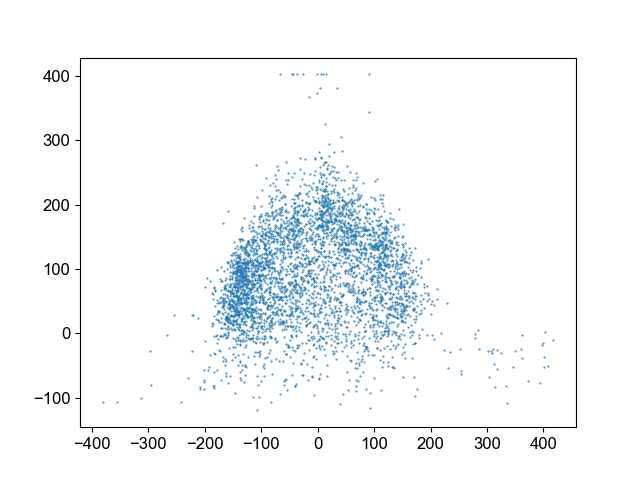

In [52]:
fig,ax = plt.subplots()
ax.scatter(storm_Data['X'],storm_Data['Y'],s=0.2)

In [1]:
# Perform the fit and transformation for all refractive indices

In [53]:
for j in range(len(STORM_locs_list)):
    print(int((j/len(STORM_locs_list))*100),'% of the analysis done')
    locS = STORM_locs_list[j]
    locS = locS.rename(columns={"z": "z_before_corr", "z_cor": "z"})
    locS_defocus = STORM_defocus_list[j]

    ###
    # sorting the data values and re-indexing
    locS = locS.sort_values('x')
    locS = locS.set_index(pd.Index(list(range(len(locS)))))


    # Threshold knots for calculating the distances:

    # filter out a cube (a=2*fl) with the poi in the center 
    fl = 500 # filter length 
    #filter function
    def filt(df, var, low, high):
        return df[(df[var]>low) & (df[var]<high)]

    Point_table = pd.DataFrame(columns=['dist','s','xs','ys','zs'])

    for k in range(len(locS['x'])):

        point_x = locS['x'].iloc[k]
        point_y = locS['y'].iloc[k]
        point_z = locS['z'].iloc[k]

        Test_table_filt = filt(AKnots, 'x_values', point_x-fl, point_x+fl)

        FR = 10000 # distance should be closer than this value (> than fibril width)
        for n in range(len(Test_table_filt)):
            FR_new_x2 = (Test_table_filt['x_values'].iloc[n]-point_x)**2
            FR_new_y2 = (Test_table_filt['y_values'].iloc[n]-point_y)**2
            FR_new_z2 = (Test_table_filt['z_values'].iloc[n]-point_z)**2
            FR_new = sqrt(FR_new_x2+FR_new_y2+FR_new_z2)

            if FR_new < FR:
                FR = FR_new
                i = n
        s = Test_table_filt['s_length'].iloc[i]
        xs = Test_table_filt['x_values'].iloc[i]
        ys = Test_table_filt['y_values'].iloc[i]
        zs = Test_table_filt['z_values'].iloc[i]

        Point_table.loc[len(Point_table)] = [FR,s,xs,ys,zs]

    storm_locs_new = locS.copy()
    storm_locs_new = pd.concat([locS, Point_table],axis=1,join = 'inner') 
    # merge the new list to the localisations


    ###
    def angle(v, w): 
        # calculation of the angle between two vectors:
        return acos(v.dot(w)/(norm(v)*norm(w)))

    # calculate the angles of the points
    X_final, Y_final, A_final = [],[],[]

    # coordinates of the spline knot:
    xri = np.array(storm_locs_new['xs'])
    yri = np.array(storm_locs_new['ys'])
    zri = np.array(storm_locs_new['zs'])

    # coordinate of the point of interest:
    pxi = np.array(storm_locs_new['x'])
    pyi = np.array(storm_locs_new['y'])
    pzi = np.array(storm_locs_new['z'])

    R_min_list = np.array(storm_locs_new['dist'])

    for m in range(len(storm_locs_new)):

        # coordinates of the spline knot:
        xr = xri[m]
        yr = yri[m]
        zr = zri[m]

        # coordinate of the point of interest:
        px = pxi[m]
        py = pyi[m]
        pz = pzi[m]

        # distance of the poi to the spline
        R_min = R_min_list[m]

        # evaluate THB for a given point (xr):
        Tp = calc_THB_point(T_storm,xr)

        # calculating the rotation such that vector T is in xy plane:
        # rotate THB around the roation axis T, 
        # so that H lies in x-y plane and has z = 0

        # define projection of T:
        Tp[2] = 0 # projecting it to the xy-plane
        pTp = Tp/norm(Tp)


        # to get the projection of H we
        # define a vector perpendicular to it:
        # (x,y,z) -> (y,-x,z) with z = 0

        pHp = pTp.copy()
        pHp[0] = pTp[1]
        pHp[1] = -pTp[0]


        if pHp[1] < 0:
            pHp = rotation(pi,pHp) # rotation to get the direction in the positive y-direction

        # pHp is the final vector to determine the angle between the horizontal (pHp) and 
        # the point of interest


        # Transform the point to the coordinate system of THB:
        # substract the point on the spline to the point of interest,
        # to get the vector of the point
        P = np.array([float(px-xr),float(py-yr),float(pz-zr)])


        # now let's calculate the angle between the point and the horizontal projection of H-vector:
        a_poi = angle(P,pHp)

        # note that we want an angle ranging from 0-360
        if P[2] < 0: 
            a_poi = 2*pi-a_poi # this ensures that the angle is always between 0 and 2pi


        # Calculate the x and y coordinates of our point of interest poi in the HB-plane:
        # the x and y values (in the HB-plane) are simply:
        X = R_min*np.cos(a_poi)
        Y = R_min*np.sin(a_poi)

        a_poi = round(degrees(a_poi),2)
        X = round(X,2)
        Y = round(Y,2)

        X_final += [X] 
        Y_final += [Y] 
        A_final += [a_poi] 


    # make a final pandas data table:
    storm_Data = pd.DataFrame(list(zip(X_final, Y_final,A_final)),
                        columns =['X','Y','Angle'])

    storm_Data = pd.concat([storm_locs_new,storm_Data], axis=1, join="inner")


    ### Saving
    save_file_name_storm_wet = results_folder+f'/storm_data_continue_def{locS_defocus}.csv'
    storm_Data.to_csv(save_file_name_storm_wet)
    print(f'Great, your data is now saved under: {save_file_name_storm_wet}')
    print(f'fibril {fibril} with def{locS_defocus} is analysed')


print('\n\n---- analysis is done ----')

0 % of the analysis done
Great, your data is now saved under: loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2/storm_data_continue_def_586_mid_219_n133_n1.33_n1518.csv
fibril fibril_5_2 with def_586_mid_219_n133_n1.33_n1518 is analysed
12 % of the analysis done
Great, your data is now saved under: loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2/storm_data_continue_def_586_mid_219_n133_n1.38_n1518.csv
fibril fibril_5_2 with def_586_mid_219_n133_n1.38_n1518 is analysed
25 % of the analysis done
Great, your data is now saved under: loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2/storm_data_continue_def_586_mid_219_n133_n1.42_n1518.csv
fibril fibril_5_2 with def_586_mid_219_n133_n1.42_n1518 is analysed
37 % of the analysis done
Great, your data is now saved under: loc_filt_GPU_results_2_1_2/fibril_5_2/analysis_ROI_2_1_2_fibril_5_2/storm_data_continue_def_586_mid_219_n133_n1.44_n1518.csv
fibril fibril_5_2 with def_586_mid_219_n133_n